In [5]:
# Run this code to unzip the Skin Diseases Data into a "dataset" folder
import zipfile as zf
files = zf.ZipFile("archive.zip", 'r')
files.extractall('dataset')
files.close()

In [9]:
# Useful Imports
import torch 
import torch.nn as nn
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score

In [2]:
# Converts every image to 256x256 dimension and into a Tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Loads each subset directory from your "dataset" folder
train_dataset = datasets.ImageFolder(root='dataset/Train', transform=transform)
test_dataset = datasets.ImageFolder(root='dataset/Test', transform=transform)
val_dataset = datasets.ImageFolder(root='dataset/Val', transform=transform)

# Hyper Parameters for dataset organization and processing
batch_size = 50
num_workers = 3

# Dataloader for each subset which will batch, shuffle, and parallel load the data
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [3]:
# Total images in each subset
print('Train data: ', len(train_dataset))
print('Test data: ', len(test_dataset))
print('Valid data: ', len(val_dataset))

Train data:  1198
Test data:  389
Valid data:  250


torch.Size([3, 256, 256])
tensor(0)


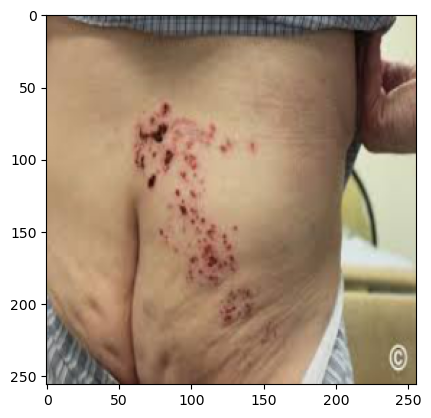

In [50]:
# Check a batch of data
images, labels = next(iter(train_dataloader))

print(images[0].size()) # Number of Colors (RGB=3), Height=256, Width=256
print(labels[0]) # Herpes=0, Melanoma=1, Monkeypox=2, Sarampion=3, Varicela=4

# Will the image sampled
image = transforms.ToPILImage()(images[0])
plt.imshow(image)
plt.show()

In [14]:
# Calculates output layer size, convenient when making multiple hidden layers
image_size = 127
kernel_size = 3
padding = 0
stride = 1
pool = 2

output_shape = np.floor((((image_size - kernel_size + (2 * padding)) / stride) + 1) / pool)
print(output_shape)

62.0


In [73]:
# Custom CNN Model

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=0), #(64, 254, 254)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #(64, 127, 127)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0), #(128, 125, 125)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #(128, 62, 62)
        
        self.fc1 = nn.Sequential(
            nn.Linear(128*62*62, 128),
            nn.ReLU())
        
        self.fc2 = nn.Linear(128, 5)

    def forward(self, out):
        out = self.conv1(out)
        out = self.conv2(out)
        out = out.view(-1, 128*62*62)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out

In [52]:
# Allows model to run on GPU if it is present
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [53]:
# Test run, should output torch.Size([batch_size, classes])
custom_cnn = CustomCNN().to(device)
output = custom_cnn(images.to(device))
print(output.size())

torch.Size([50, 5])


In [74]:
# Declare Model
custom_cnn = CustomCNN().to(device)

# Set Hyper Parameters
epochs = 2
learning_rate = 0.01

# Declare Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_cnn.parameters(), lr = learning_rate)

In [75]:
# Train the model
total_step = len(train_dataloader)
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = custom_cnn(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                .format(epoch+1, epochs, i+1, total_step, loss.item()))

Epoch [1/2], Step [1/24], Loss: 1.6123
Epoch [1/2], Step [2/24], Loss: 780.0849
Epoch [1/2], Step [3/24], Loss: 178.0292
Epoch [1/2], Step [4/24], Loss: 11.6480
Epoch [1/2], Step [5/24], Loss: 13.8909
Epoch [1/2], Step [6/24], Loss: 6.5515
Epoch [1/2], Step [7/24], Loss: 22.3832
Epoch [1/2], Step [8/24], Loss: 4.7374
Epoch [1/2], Step [9/24], Loss: 1.6474
Epoch [1/2], Step [10/24], Loss: 1.6330
Epoch [1/2], Step [11/24], Loss: 1.6269
Epoch [1/2], Step [12/24], Loss: 1.6239
Epoch [1/2], Step [13/24], Loss: 1.6117
Epoch [1/2], Step [14/24], Loss: 1.6034
Epoch [1/2], Step [15/24], Loss: 1.6209
Epoch [1/2], Step [16/24], Loss: 1.6244
Epoch [1/2], Step [17/24], Loss: 1.6137
Epoch [1/2], Step [18/24], Loss: 1.5950
Epoch [1/2], Step [19/24], Loss: 1.6257
Epoch [1/2], Step [20/24], Loss: 1.6179
Epoch [1/2], Step [21/24], Loss: 1.5983
Epoch [1/2], Step [22/24], Loss: 1.6229
Epoch [1/2], Step [23/24], Loss: 1.6155
Epoch [1/2], Step [24/24], Loss: 1.6214
Epoch [2/2], Step [1/24], Loss: 1.6098
Epo

In [76]:
# Define a calculate_accuracy function
def calculate_accuracy(model, dataloader, device):
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
    
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
    
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')

In [77]:
# Calculate validation accuracy of model
calculate_accuracy(custom_cnn, val_dataloader, device)

Accuracy: 20.0%
